# Clustering Baselines using Embeddings as a Feature

In [1]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import os
os.chdir('../')
from clustering_evaluation import ClusterPurity
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import numpy as np
import hdbscan

# Load The Dataset (AI4BD):

In [2]:
# -- load the input dataset--#
input_df=pd.read_csv('/home/daikiri/DAIKIRI/src/Hamada/merged.csv', low_memory=False)
input_df.index = 'Event_' + input_df.index.astype(str)
num_rows, num_cols = input_df.shape  # at max num_rows times num_cols columns.
column_names = input_df.columns
    
print ('Input data loaded with shape', input_df.shape) 

# binarize string_labels in ['type']
lb=LabelBinarizer()
event_labels=lb.fit_transform(input_df['type'].tolist())
lb.classes_


Input data loaded with shape (2974716, 41)


array(['order', 'stock change'], dtype='<U12')

In [3]:
input_df.head()

,customer_id,customer_name,site_id,customer_number,op_group_id,logistic_type,location_uuid,assortment_uuid,customer_item_number,supplier_id,...,deliver_mon,deliver_tue,deliver_wed,deliver_thu,deliver_fri,start_week,every_week,week_of_month,positive_stock_change,relative_class
Event_0,5800860,customer_b,5317663159,S300034,5.328103e+09,SMART_BIN_CLASSIC,196492C81502483B93A2628C76942705,DE08C08DB85947D8AEF79391FDEF8241,520011582,5319379052,...,True,True,True,True,True,1.0,True,NaN,False,>=100%
Event_1,5800860,customer_b,5317663159,S300034,5.328103e+09,SMART_BIN_CLASSIC,196492C81502483B93A2628C76942705,DE08C08DB85947D8AEF79391FDEF8241,520011582,5319379052,...,True,True,True,True,True,1.0,True,NaN,True,>=25 <50%
Event_2,5800860,customer_b,5317663159,S300034,5.328103e+09,SMART_BIN_CLASSIC,196492C81502483B93A2628C76942705,DE08C08DB85947D8AEF79391FDEF8241,520011582,5319379052,...,True,True,True,True,True,1.0,True,NaN,True,>=25 <50%
Event_3,5800860,customer_b,5317663159,S300034,5.328103e+09,SMART_BIN_CLASSIC,196492C81502483B93A2628C76942705,DE08C08DB85947D8AEF79391FDEF8241,520011582,5319379052,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,>=2 <4%
Event_4,5800860,customer_b,5317663159,S300034,5.328103e+09,SMART_BIN_CLASSIC,196492C81502483B93A2628C76942705,DE08C08DB85947D8AEF79391FDEF8241,520011582,5319379052,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,>=100%


In [4]:
#-- load the embeddings data --#
embedding_input=pd.read_csv('/home/daikiri/DAIKIRI/src/Hamada/Vectograph_Results/2020-08-08 01:00:07.899851/PYKE_50_embd.csv', index_col=0, low_memory=False)

#consider only events embedding (Event_id)
embedding_index=embedding_input.index.tolist()
prefix = 'Event_'
event_ids=list(filter(lambda x: x.startswith(prefix), embedding_index))
events_df=embedding_input.loc[event_ids]

In [5]:
events_df.head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
Event_0,0.999795,0.506241,0.999795,0.506241,0.506241,0.999795,0.506241,0.506241,0.999795,0.999795,...,0.999795,0.999795,0.999795,0.999795,0.506241,0.506241,0.999795,0.999795,0.999795,0.265385
Event_1,0.999795,0.506806,0.999795,0.506806,0.506806,0.999795,0.506806,0.506806,0.999795,0.999795,...,0.999795,0.999795,0.999795,0.999795,0.506806,0.506806,0.999795,0.999795,0.999795,0.265368
Event_2,0.999795,0.509520,0.999795,0.509520,0.509520,0.999795,0.509520,0.509520,0.999795,0.999795,...,0.999795,0.999795,0.999795,0.999795,0.509520,0.509520,0.999795,0.999795,0.999795,0.265371
Event_3,0.999795,0.505812,0.999795,0.505812,0.505812,0.999795,0.505812,0.505812,0.999795,0.999795,...,0.999795,0.999795,0.999795,0.999795,0.505812,0.505812,0.999795,0.999795,0.999795,0.265372
Event_4,0.999795,0.504836,0.999795,0.504836,0.504836,0.999795,0.504836,0.504836,0.999795,0.999795,...,0.999795,0.999795,0.999795,0.999795,0.504836,0.504836,0.999795,0.999795,0.999795,0.265372


In [14]:
# check two dataframes have the same indices #
input_df.index.identical(events_df.index) 

True

In [15]:
# split the dataset into train-test split
X_train, X_test, y_train, y_test = train_test_split( events_df.values, event_labels, test_size=0.33, random_state=42)

## Baseline_1: Logisitc Regression:

In [49]:
logistic_clf = LogisticRegression(solver='liblinear',random_state=42).fit(X_train, y_train)
y_predicted = logistic_clf.predict(X_test)

/home/daikiri/.conda/envs/daikiri/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [50]:
#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test2, y_predicted)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test2, y_predicted)
print('Precision: %f' % precision)

recall = recall_score(y_test2, y_predicted)
print('Recall: %f' % recall)

f1 = f1_score(y_test2, y_predicted)
print('F1 score: %f' % f1)

Accuracy: 0.976017
Precision: 0.976017
Recall: 1.000000
F1 score: 0.987863


In [51]:
#------------- Evaluation based on cluster_purity metric: -----------------#
evaluator=ClusterPurity()
purity_score=evaluator.purity_score(y_true=y_test, y_pred=y_predicted)

print('Clustering Purity Score: ', purity_score)

Clustering Purity Score:  0.9760170813227024


[Text(0, 0.5, 'order'), Text(0, 1.5, 'stock change')]

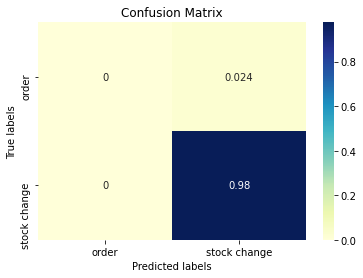

In [54]:
#------------- Confusion Matrix ------------------#
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt  

labels=[0, 1]
cm= confusion_matrix(y_test, y_predicted, labels, normalize='all')
ax= plt.subplot()

sns.heatmap(cm, annot=True, ax = ax, cmap="YlGnBu"); #annot=True to annotate cells

# # labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['order', 'stock change'])
ax.yaxis.set_ticklabels(['order', 'stock change'])

# Baseline_2: K-mean

In [43]:
kmeans = KMeans(n_clusters=2, random_state=42).fit(events_df.values)
y_predicted=kmeans.predict(events_df.values)

In [44]:
#------------- Evaluation based on cluster_purity metric: -----------------#
purity_score=evaluator.purity_score(y_true=event_labels, y_pred=y_predicted)
print('Clustering Purity Score: ', purity_score)

Clustering Purity Score:  0.9760810779919831


In [45]:
#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(event_labels, y_predicted)
print('Accuracy: %f' % accuracy)

precision = precision_score(event_labels, y_predicted)
print('Precision: %f' % precision)

recall = recall_score(event_labels, y_predicted)
print('Recall: %f' % recall)

f1 = f1_score(event_labels, y_predicted)
print('F1 score: %f' % f1)

Accuracy: 0.024060
Precision: 0.995294
Recall: 0.000146
F1 score: 0.000291


[Text(0, 0.5, 'order'), Text(0, 1.5, 'stock change')]

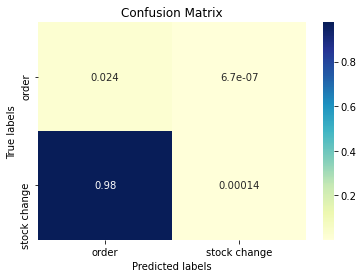

In [47]:
labels=[0, 1]
cm= confusion_matrix(event_labels, y_predicted, labels, normalize='all')
ax= plt.subplot()

sns.heatmap(cm, annot=True, ax = ax, cmap="YlGnBu"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['order', 'stock change'])
ax.yaxis.set_ticklabels(['order', 'stock change'])

# Baseline_3: KNN 

In [55]:
neigh = KNeighborsClassifier(n_neighbors=1).fit(X_train, y_train)

y_predicted = neigh.predict(X_test)

/home/daikiri/.conda/envs/daikiri/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """Entry point for launching an IPython kernel.


In [56]:
#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_predicted)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_predicted)
print('Precision: %f' % precision)

recall = recall_score(y_test, y_predicted)
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_predicted)
print('F1 score: %f' % f1)

Accuracy: 0.954594
Precision: 0.976429
Recall: 0.977064
F1 score: 0.976747


In [57]:
#------------- Evaluation based on cluster_purity metric: -----------------#
purity_score=evaluator.purity_score(y_true=y_test, y_pred=y_predicted)
print('Clustering Purity Score: ', purity_score)

Clustering Purity Score:  0.9760170813227024


/home/daikiri/.conda/envs/daikiri/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass labels=[0, 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[Text(0, 0.5, 'order'), Text(0, 1.5, 'stock change')]

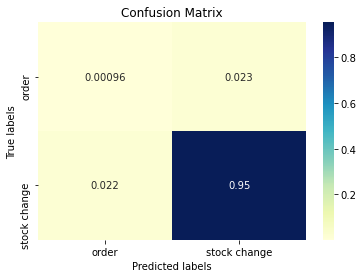

In [58]:
labels=[0, 1]
cm= confusion_matrix(y_test, y_predicted, labels, normalize='all')
ax= plt.subplot()

sns.heatmap(cm, annot=True, ax = ax, cmap="YlGnBu"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['order', 'stock change'])
ax.yaxis.set_ticklabels(['order', 'stock change'])

# Baseline_4: RandomForest

In [59]:
random_clf = RandomForestClassifier(max_depth=2, random_state=42).fit(X_train, y_train)
y_predicted= random_clf.predict(X_test)

/home/daikiri/.conda/envs/daikiri/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


In [60]:
#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(y_test, y_predicted)
print('Accuracy: %f' % accuracy)

precision = precision_score(y_test, y_predicted)
print('Precision: %f' % precision)

recall = recall_score(y_test, y_predicted)
print('Recall: %f' % recall)

f1 = f1_score(y_test, y_predicted)
print('F1 score: %f' % f1)

Accuracy: 0.976017
Precision: 0.976017
Recall: 1.000000
F1 score: 0.987863


In [61]:
#------------- Evaluation based on cluster_purity metric: -----------------#
purity_score=evaluator.purity_score(y_true=y_test, y_pred=y_predicted)
print('Clustering Purity Score: ', purity_score)

Clustering Purity Score:  0.9760170813227024


[Text(0, 0.5, 'order'), Text(0, 1.5, 'stock change')]

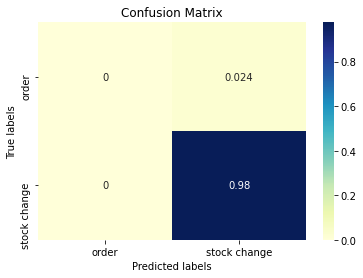

In [63]:
labels=[0, 1]
cm= confusion_matrix(y_test, y_predicted, labels, normalize='all')
ax= plt.subplot()

sns.heatmap(cm, annot=True, ax = ax, cmap="YlGnBu"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['order', 'stock change'])
ax.yaxis.set_ticklabels(['order', 'stock change'])

# Baseline_5: Random Clustering

In [64]:
labels_random=np.random.randint(2, size=input_df.shape[0])

#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(event_labels, labels_random)
print('Accuracy: %f' % accuracy)

precision = precision_score(event_labels, labels_random)
print('Precision: %f' % precision)

recall = recall_score(event_labels, labels_random)
print('Recall: %f' % recall)

f1 = f1_score(event_labels, labels_random)
print('F1 score: %f' % f1)

#------------- Evaluation based on cluster_purity metric: -----------------#
evaluator=ClusterPurity()
purity_score=evaluator.purity_score(y_true=event_labels, y_pred=labels_random)

print('Clustering Purity Score: ', purity_score)

Accuracy: 0.499464
Precision: 0.976055
Recall: 0.499451
F1 score: 0.660779
Clustering Purity Score:  0.9760810779919831


[Text(0, 0.5, 'order'), Text(0, 1.5, 'stock change')]

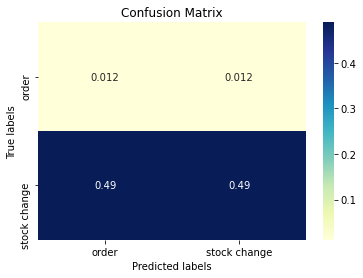

In [65]:
labels=[0, 1]
cm= confusion_matrix(event_labels, labels_random, labels, normalize='all')
ax= plt.subplot()

sns.heatmap(cm, annot=True, ax = ax, cmap="YlGnBu"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['order', 'stock change'])
ax.yaxis.set_ticklabels(['order', 'stock change'])

---

# Clustering based on (1/2) Columns:

In [29]:
column_names

Index(['customer_id', 'customer_name', 'site_id', 'customer_number',
       'op_group_id', 'logistic_type', 'location_uuid', 'assortment_uuid',
       'customer_item_number', 'supplier_id', 'supplier_item_number',
       'box_number_in_site', 'replenished_at', 'old_stock', 'new_stock',
       'type', 'order_number', 'site_number', 'order_pos', 'ordering_at',
       'order_priority', 'ordered_qty', 'delivery_qty', 'requesting_at',
       'shipping_at', 'confirmed_at', 'confirming_at', 'physical_address',
       'no_of_boxes', 'reorder_quantity', 'reorder_point', 'deliver_mon',
       'deliver_tue', 'deliver_wed', 'deliver_thu', 'deliver_fri',
       'start_week', 'every_week', 'week_of_month', 'positive_stock_change',
       'relative_class'],
      dtype='object')

In [30]:
# Clustering using HDBSCAN based column (box_number_in_site)
input_df_col1=input_df[['box_number_in_site', 'type']]
print (input_df_col1.shape)

input_df_col1=input_df_col1.dropna()


(2974716, 2)


In [31]:
true_labels=lb.fit_transform(input_df_col1['type'].tolist())
lb.classes_


array(['order', 'stock change'], dtype='<U12')

In [33]:
input_df_col1=input_df_col1[['box_number_in_site']]


In [34]:
##-- Cluster the data using HDBSCAN 
clusterer = hdbscan.HDBSCAN( algorithm= 'best',  alpha=1.3,  approx_min_span_tree=True,  
                            metric='euclidean', gen_min_span_tree= True, min_cluster_size=10000, 
                            min_samples= 100,cluster_selection_epsilon= 0.5, core_dist_n_jobs=1, allow_single_cluster=False).fit(input_df_col1)
    
input_df_col1['cluster_preds']=clusterer.labels_    
print ('Number of Clusters: ',len(set(clusterer.labels_)))

Number of Clusters:  92


In [35]:
labels_predicted=input_df_col1['cluster_preds'].tolist()

In [36]:
#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(true_labels, labels_predicted)
print('Accuracy: %f' % accuracy)

precision = precision_score(true_labels, labels_predicted, average='macro')
print('Precision: %f' % precision)

recall = recall_score(true_labels, labels_predicted, average='macro')
print('Recall: %f' % recall)

f1 = f1_score(true_labels, labels_predicted, average='macro')
print('F1 score: %f' % f1)

#------------- Evaluation based on cluster_purity metric: -----------------#
evaluator=ClusterPurity()
purity_score=evaluator.purity_score(y_true=true_labels, y_pred=labels_predicted)

print('Clustering Purity Score: ', purity_score)

Accuracy: 0.006979
Precision: 0.010900


/home/daikiri/.conda/envs/daikiri/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall: 0.000248
F1 score: 0.000437
Clustering Purity Score:  0.9760817342440316


---

## Clustering based on Two Columns

In [38]:
sub_input_df=input_df[['positive_stock_change','relative_class']]
train_as_dicts = [dict(r.iteritems()) for _, r in sub_input_df.iterrows()]

In [39]:
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer(sparse=True)
vectorized_sparse = vectorizer.fit_transform(train_as_dicts)

X_Data=vectorized_sparse.toarray()

In [40]:
##-- Cluster the data using HDBSCAN 
clusterer = hdbscan.HDBSCAN( algorithm= 'best',  alpha=1.3,  approx_min_span_tree=True,  
                            metric='euclidean', gen_min_span_tree= True, min_cluster_size=10000, 
                            min_samples= 100,cluster_selection_epsilon= 0.5, core_dist_n_jobs=1, allow_single_cluster=False).fit(X_Data)
    
print ('Number of Clusters: ',len(set(clusterer.labels_)))

In [ ]:
true_labels=lb.fit_transform(input_df_col1['type'].tolist())
labels_predicted=input_df_col1['cluster_preds'].tolist()

#----------- Evaluation based on Precision, Recall, Accuracy and F1-score: -------#
accuracy = accuracy_score(true_labels, labels_predicted)
print('Accuracy: %f' % accuracy)

precision = precision_score(true_labels, labels_predicted, average='macro')
print('Precision: %f' % precision)

recall = recall_score(true_labels, labels_predicted, average='macro')
print('Recall: %f' % recall)

f1 = f1_score(true_labels, labels_predicted, average='macro')
print('F1 score: %f' % f1)

#------------- Evaluation based on cluster_purity metric: -----------------#
evaluator=ClusterPurity()
purity_score=evaluator.purity_score(y_true=true_labels, y_pred=labels_predicted)

print('Clustering Purity Score: ', purity_score)

In [ ]:
labels=[0, 1]
cm= confusion_matrix(event_labels, y_predicted, labels, normalize='all')
ax= plt.subplot()

sns.heatmap(cm, annot=True, ax = ax, cmap="YlGnBu"); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels') 
ax.set_title('Confusion Matrix') 
ax.xaxis.set_ticklabels(['order', 'stock change'])
ax.yaxis.set_ticklabels(['stock change', 'order'])